# Data preparation

## Setup

In [1]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)

Windows-10-10.0.19045-SP0
Python 3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]


In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="muted")

## Load data

In [3]:
data_path = '../data/interim/1_feature_engineering/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')

In [4]:
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col not in [TARGET]]

numerical = train[FEATURES].select_dtypes(include=np.number).columns
categorical = train[FEATURES].select_dtypes(exclude=np.number).columns

print(f'Target: {TARGET}')
print(f'Features:\n\tnumerical: {numerical.to_list()}\n\tcategorical:{categorical.to_list()}')
print(f'Shapes:\n\ttrain: {train.shape}\n\ttest: {test.shape}')

train.head()

Target: Transported
Features:
	numerical: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Group', 'Expenditure', 'CabinNum', 'GroupSize', 'FamilySize']
	categorical:['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Surname', 'NoSpending', 'CabinDeck', 'CabinSide', 'AgeGroup', 'Solo', 'CabinGroup']
Shapes:
	train: (8693, 24)
	test: (4277, 23)


,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Expenditure,NoSpending,CabinDeck,CabinNum,CabinSide,AgeGroup,GroupSize,FamilySize,Solo,CabinGroup
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,0.0,True,B,0.0,P,"(30, 40]",1,3.0,True,"(-10, 300]"
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,736.0,False,F,0.0,S,"(17, 25]",1,4.0,True,"(-10, 300]"
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,10383.0,False,A,0.0,S,"(50, 99]",2,7.0,False,"(-10, 300]"
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,5176.0,False,A,0.0,S,"(30, 40]",2,7.0,False,"(-10, 300]"
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,1091.0,False,F,1.0,S,"(12, 17]",1,9.0,True,"(-10, 300]"


## Missing values

(taken from [this Kaggle Notebook](https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide#EDA))

In [5]:
# concatenate dataframes
y = train[TARGET].copy().astype(int)
X = train.drop(TARGET, axis=1).copy()

data = pd.concat([X, test], axis=0)#.reset_index(drop=True)

In [6]:
# columns with missing values
na_cols = data.columns[data.isna().any()].tolist()

# missing values summary
mv = pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing'] = np.round(100*mv['Number_missing']/len(data),2)
mv

,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


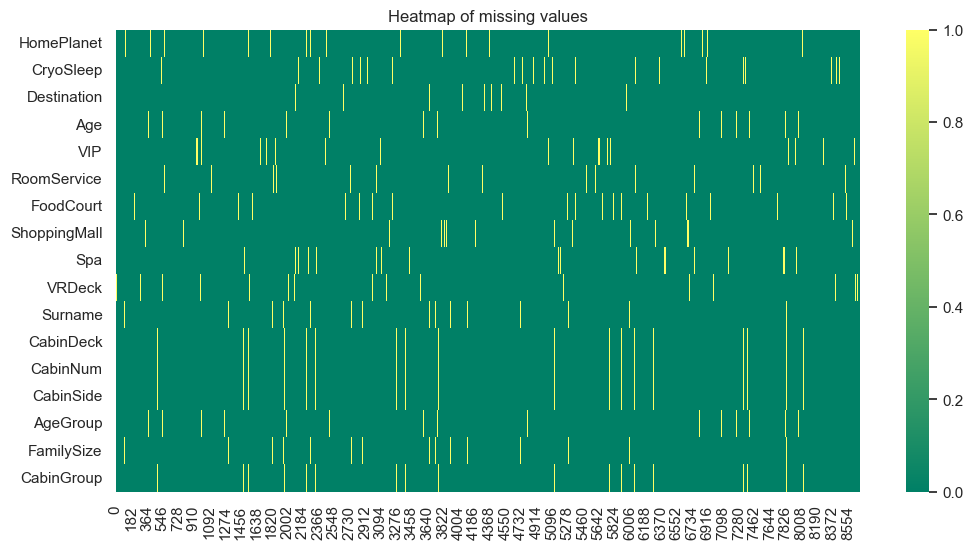

In [7]:
# heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(train[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')
plt.savefig('figures/eda_1/heatmap_missingvalues')

### HomePlanet

In [8]:
# joint distribution of Surname and HomePlanet
SHP_gb=data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
(SHP_gb>0).sum(axis=1).value_counts()

1    2400
dtype: int64

In [9]:
# we can impute missing values for HomePlanet based on Surname
# missing values before
nas_bef = data['HomePlanet'].isna().sum()

# fill corresponding missing values
mask = (data['HomePlanet'].isna()) & (data['Surname'].isin(SHP_gb.index))
data.loc[mask, 'HomePlanet'] = data.loc[mask, 'Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# print number of missing values left
print('HomePlanet missing values before:', nas_bef)
print('HomePlanet missing values after:', data['HomePlanet'].isna().sum())

HomePlanet missing values before: 288
HomePlanet missing values after: 17


In [10]:
# joint distribution of Group and HomePlanet
GHP_gb = data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1.0,0.0,1.0,0.0
2.0,1.0,0.0,0.0
3.0,0.0,2.0,0.0
4.0,1.0,0.0,0.0
5.0,1.0,0.0,0.0


In [11]:
# missing values before
nas_bef = data['HomePlanet'].isna().sum()

# fill corresponding missing values
mask = (data['HomePlanet'].isna()) & (data['Group'].isin(GHP_gb.index))
data.loc[mask,'HomePlanet'] = data.loc[mask, 'Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# print number of missing values left
print('HomePlanet missing values before:', nas_bef)
print('HomePlanet missing values after:', data['HomePlanet'].isna().sum())

HomePlanet missing values before: 17
HomePlanet missing values after: 13


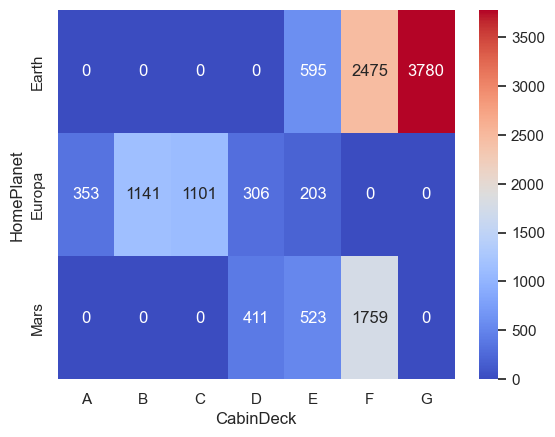

In [12]:
# joint distribution of CabinDeck and HomePlanet
CDHP_gb = data.groupby(['CabinDeck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# heatmap of missing values
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')
plt.savefig('figures/eda_1/heatmap_homeplanet_cabindeck.png')

In [13]:
# missing values before
nas_bef = data['HomePlanet'].isna().sum()

# decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['CabinDeck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'

# deck G came from Earth
data.loc[(data['HomePlanet'].isna()) & (data['CabinDeck']=='G'), 'HomePlanet'] = 'Earth'

# print number of missing values left
print('HomePlanet missing values before:', nas_bef)
print('HomePlanet missing values after:', data['HomePlanet'].isna().sum())

HomePlanet missing values before: 13
HomePlanet missing values after: 10


In [14]:
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
276,0616_01,NaN,TRAPPIST-1e
1890,4052_01,NaN,TRAPPIST-1e
3220,7065_01,NaN,TRAPPIST-1e
3858,8435_01,NaN,TRAPPIST-1e
4032,8775_01,NaN,TRAPPIST-1e


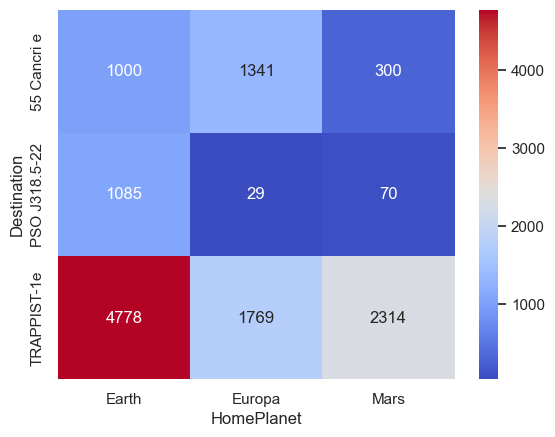

In [15]:
# joint distribution of HomePlanet and Destination
HPD_gb = data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

# heatmap of missing values
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')
plt.savefig('figures/eda_1/heatmap_homeplanet_destination.png')

In [16]:
# missing values before
nas_bef = data['HomePlanet'].isna().sum()

# fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['HomePlanet'].isna()) & ~(data['CabinDeck']=='D'), 'HomePlanet'] = 'Earth'
data.loc[(data['HomePlanet'].isna()) & (data['CabinDeck']=='D'), 'HomePlanet'] = 'Mars'

# print number of missing values left
print('HomePlanet missing values before:', nas_bef)
print('HomePlanet missing values after:', data['HomePlanet'].isna().sum())

HomePlanet missing values before: 10
HomePlanet missing values after: 0


### Destination

In [17]:
# missing values before
nas_bef = data['Destination'].isna().sum()

# fill missing Destination values with mode
data.loc[(data['Destination'].isna()), 'Destination'] = 'TRAPPIST-1e'

# print number of missing values left
print('Destination missing values before:', nas_bef)
print('Destination missing values after:', data['Destination'].isna().sum())

Destination missing values before: 274
Destination missing values after: 0


### Surname and Group

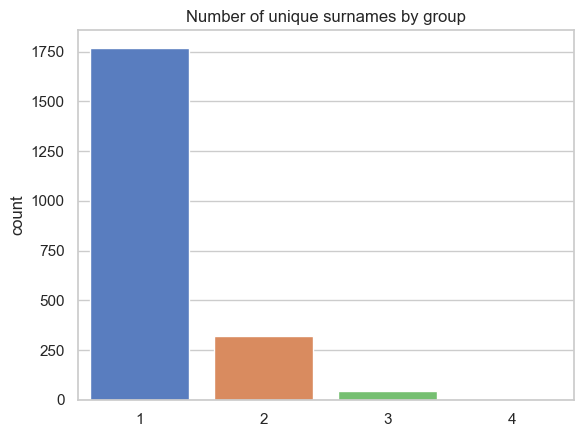

In [18]:
# joint distribution of Group and Surname
GSN_gb = data[data['GroupSize']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)

# countplot of unique values
sns.countplot(x=(GSN_gb>0).sum(axis=1))
plt.title('Number of unique surnames by group')
plt.savefig('figures/eda_1/countplot_surname_group')

In [19]:
# surname
# missing values before
nas_bef = data['Surname'].isna().sum()

# fill  missing values
mask = (data['Surname'].isna()) & (data['Group'].isin(GSN_gb.index))
data.loc[mask, 'Surname'] = data.loc[mask, 'Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# print number of missing values left
print('Surname missing values before:', nas_bef)
print('Surname missing values after:', data['Surname'].isna().sum())

Surname missing values before: 294
Surname missing values after: 155


In [20]:
# replace NaN's with outliers (so we can use map)
data['Surname'].fillna('Unknown', inplace=True)

# update family size feature
tomerge = data[['Surname', 'PassengerId']].groupby('Surname').count().rename(columns={'PassengerId': 'FamilySize'})
data = data.drop('FamilySize', axis=1).join(tomerge, on='Surname')

# put NaN's back in place of outliers
data.loc[data['Surname']=='Unknown','Surname']=np.nan

# say unknown surname means no family
data.loc[data['FamilySize']>100, 'FamilySize']=0

### CabinSide and Group

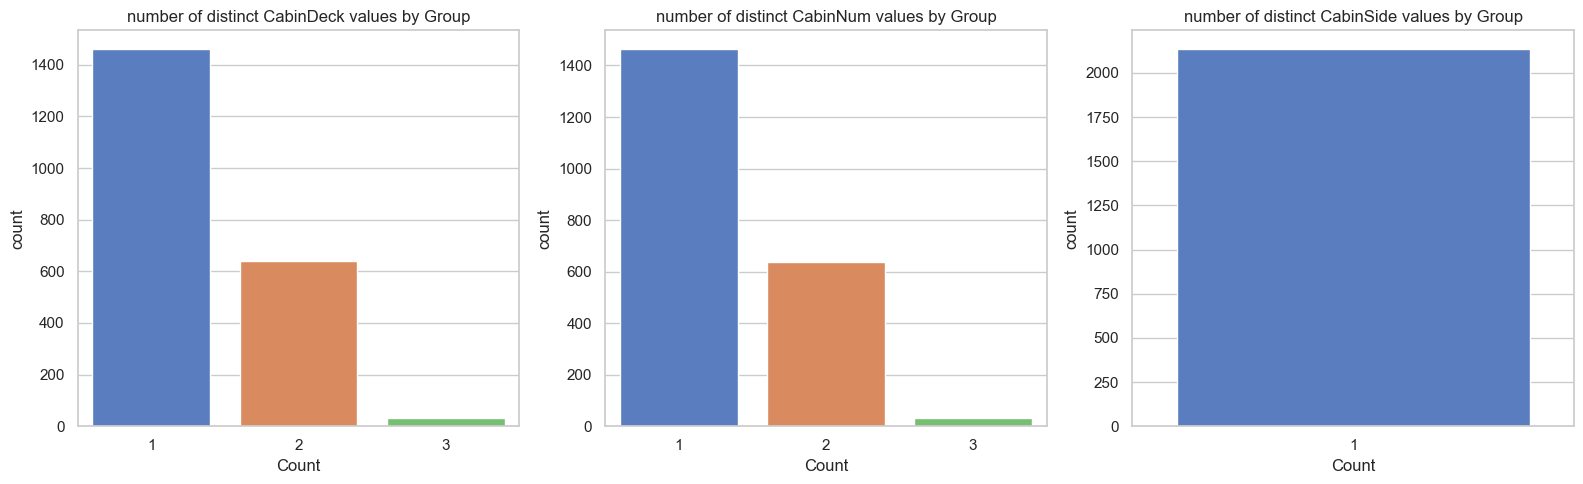

In [21]:
# Joint distribution of Group and Cabin features
GCD_gb = data[data['GroupSize']>1].groupby(['Group','CabinDeck'])['CabinDeck'].size().unstack().fillna(0)
GCN_gb = data[data['GroupSize']>1].groupby(['Group','CabinNum'])['CabinNum'].size().unstack().fillna(0)
GCS_gb = data[data['GroupSize']>1].groupby(['Group','CabinSide'])['CabinSide'].size().unstack().fillna(0)

# Countplots
fig = plt.figure(figsize=(16, 5))
plt.subplot(1,3,1)
a = pd.DataFrame((GCD_gb>0).sum(axis=1), columns=['Count'])
sns.countplot(x=a['Count']).set_title('number of distinct CabinDeck values by Group')

plt.subplot(1,3,2)
a = pd.DataFrame((GCN_gb>0).sum(axis=1), columns=['Count'])
sns.countplot(x=a['Count']).set_title('number of distinct CabinNum values by Group')

plt.subplot(1,3,3)
a = pd.DataFrame((GCS_gb>0).sum(axis=1), columns=['Count'])
sns.countplot(x=a['Count']).set_title('number of distinct CabinSide values by Group')

fig.tight_layout()
plt.savefig('figures/eda_1/countplot_group_cabin_feats.png')

In [22]:
# cabin side (everyone on the same cabin group is also on the same cabin side)
# missing values before
CS_bef = data['CabinSide'].isna().sum()

# fill missing values
mask = (data['CabinSide'].isna()) & (data['Group'].isin(GCS_gb.index))
data.loc[mask, 'CabinSide'] = data.loc[mask, 'Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('CabinSide missing values before:', CS_bef)
print('CabinSide missing values after:', data['CabinSide'].isna().sum())


CabinSide missing values before: 299
CabinSide missing values after: 162


### CabinSide and Surname

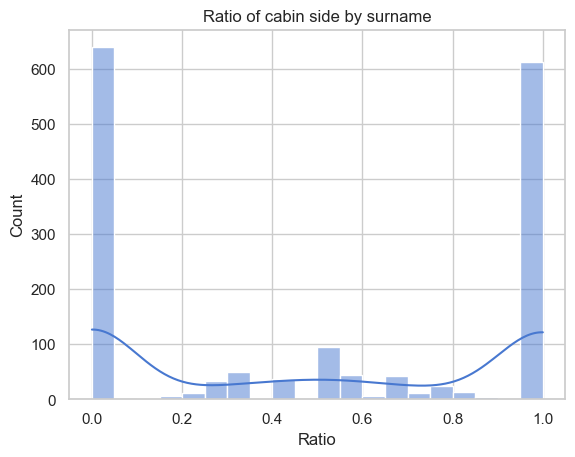

In [23]:
# joint distribution of Surname and Cabin side
SCS_gb = data[data['GroupSize']>1].groupby(['Surname','CabinSide'])['CabinSide'].size().unstack().fillna(0)

# ratio of sides
SCS_gb['Ratio'] = SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])

# histogram of ratio
sns.histplot(SCS_gb['Ratio'], kde=True, binwidth=0.05)
plt.title('Ratio of cabin side by surname')
plt.savefig('figures/eda_1/histplot_cabin_surname_ratio.png')

In [24]:
# print proportion
print('Percentage of families all on the same cabin side:', 100*np.round((SCS_gb['Ratio'].isin([0,1])).sum()/len(SCS_gb),3),'%')

# another view of the same information
SCS_gb.head()

Percentage of families all on the same cabin side: 76.7 %


CabinSide,P,S,Ratio
Surname,,,
Acobson,0.0,3.0,0.0
Acobsond,3.0,0.0,1.0
Adavisons,6.0,0.0,1.0
Admingried,0.0,4.0,0.0
Aginge,3.0,0.0,1.0


In [25]:
# cabin side (families tend to be on the same side)
# missing values before
CS_bef = data['CabinSide'].isna().sum()

# joint distribution of Surname and Cabin side
SCS_gb = data[data['GroupSize']>1].groupby(['Surname','CabinSide'])['CabinSide'].size().unstack().fillna(0)

# passengers with missing Cabin side and in a family with known Surname
mask = (data['CabinSide'].isna()) & (data['Surname'].isin(SCS_gb.index))

# fill missing values
data.loc[mask,'CabinSide'] = data.loc[mask, 'Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

# print number of missing values left
print('CabinSide missing values before:', CS_bef)
print('CabinSide missing values after:', data['CabinSide'].isna().sum())

CabinSide missing values before: 162
CabinSide missing values after: 66


In [26]:
# replace other missing values with other value since the values are balanced
data['CabinSide'].fillna('missing', inplace=True)
print('CabinSide missing values:', data['CabinSide'].isna().sum())

CabinSide missing values: 0


### CabinDeck and Group

In [27]:
# cabin deck
# missing values before
CD_bef = data['CabinDeck'].isna().sum()

# passengers with missing Cabin deck and in a group with known majority Cabin deck
mask = (data['CabinDeck'].isna()) & (data['Group'].isin(GCD_gb.index))

# fill corresponding missing values
data.loc[mask,'CabinDeck'] = data.loc[mask, 'Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

# print number of missing values left
print('CabinDeck missing values before:', CD_bef)
print('CabinDeck missing values after:', data['CabinDeck'].isna().sum())

CabinDeck missing values before: 310
CabinDeck missing values after: 173


### CabinDeck and HomePlanet

In [28]:
# joint distribution
data.groupby(['HomePlanet','Destination','Solo','CabinDeck'])['CabinDeck'].size().unstack().fillna(0)

CabinDeck                           A      B      C      D      E       F  \
HomePlanet Destination   Solo                                               
Earth      55 Cancri e   False    0.0    0.0    0.0    0.0   20.0    90.0   
                         True     0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 False    0.0    0.0    0.0    0.0   18.0    67.0   
                         True     0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   False    0.0    0.0    0.0    0.0  133.0   438.0   
                         True     0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   False   96.0  377.0  313.0   59.0   35.0     0.0   
                         True    67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 False    2.0    5.0   11.0    0.0    0.0     0.0   
                         True     0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   False  152.0  459.0  428.0  120.0   53.0     0.0   
                         True    44.0  179.0  201.0   84.0   82.0     0.0   
Mars       55 Cancri e   False    0.0    0.0    0.0   32.0   15.0   104.0   
                         True     0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 False    0.0    0.0    0.0    8.0    9.0    14.0   
                         True     0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   False    0.0    0.0    0.0  168.0  219.0   798.0   
                         True     0.0    0.0    0.0  164.0  263.0   743.0   

CabinDeck                            G  
HomePlanet Destination   Solo           
Earth      55 Cancri e   False   272.0  
                         True    269.0  
           PSO J318.5-22 False   230.0  
                         True    466.0  
           TRAPPIST-1e   False  1075.0  
                         True   1509.0  
Europa     55 Cancri e   False     0.0  
                         True      0.0  
           PSO J318.5-22 False     0.0  
                         True      0.0  
           TRAPPIST-1e   False     0.0  
                         True      0.0  
Mars       55 Cancri e   False     0.0  
                         True      0.0  
           PSO J318.5-22 False     0.0  
                         True      0.0  
           TRAPPIST-1e   False     0.0  
                         True      0.0

In [29]:
# missing values before
CD_bef = data['CabinDeck'].isna().sum()

# fill missing values using the mode
mask = data['CabinDeck'].isna()
data.loc[mask ,'CabinDeck'] = data.groupby(['HomePlanet','Destination','Solo'])['CabinDeck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[mask]

# print number of missing values left
print('CabinDeck missing values before:', CD_bef)
print('CabinDeck missing values after:', data['CabinDeck'].isna().sum())

CabinDeck missing values before: 173
CabinDeck missing values after: 0


### CabinNum and CabinDeck

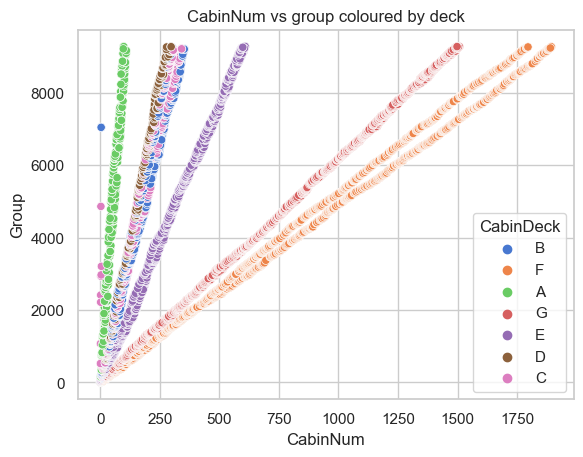

In [30]:
# scatterplot
sns.scatterplot(x=data['CabinNum'], y=data['Group'].astype(int), hue=data['CabinDeck'])#, c=LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(),'Cabin_deck']), cmap='tab10')
plt.title('CabinNum vs group coloured by deck')
plt.savefig('figures/eda_1/scatter_cabinnum_cabindeck.png')

In [31]:
# missing values before
CN_bef = data['CabinNum'].isna().sum()

# extrapolate linear relationship on a deck by deck basis
from sklearn.linear_model import LinearRegression
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    
    # features and labels
    X_CN = data.loc[~(data['CabinNum'].isna()) & (data['CabinDeck']==deck),'Group']
    y_CN = data.loc[~(data['CabinNum'].isna()) & (data['CabinDeck']==deck),'CabinNum']
    X_test_CN = data.loc[(data['CabinNum'].isna()) & (data['CabinDeck']==deck),'Group']

    # linear regression
    model_CN = LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN = model_CN.predict(X_test_CN.values.reshape(-1, 1))
    
    # fill missing values with predictions
    data.loc[(data['CabinNum'].isna()) & (data['CabinDeck']==deck),'CabinNum'] = preds_CN.astype(int)

# print number of missing values left
print('CabinNum missing values before:', CN_bef)
print('CabinNum missing values after:', data['CabinNum'].isna().sum())

# cut Cabin number into bins
print('CabinGroup missing values before:', data['CabinGroup'].isna().sum())
data['CabinGroup']=pd.cut(data['CabinNum'], bins=[-10, 300, 600, 900, 1200, 1500, 1800, 2500]).astype(object)
print('CabinGroup missing values after:', data['CabinGroup'].isna().sum())

CabinNum missing values before: 299
CabinNum missing values after: 0
CabinGroup missing values before: 299
CabinGroup missing values after: 0


### VIP

In [32]:
data['VIP'].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [33]:
# missing values before
V_bef = data['VIP'].isna().sum()

# fill missing values with mode
data.loc[data['VIP'].isna(), 'VIP'] = False

# print number of missing values left
print('VIP missing values before:', V_bef)
print('VIP missing values after:', data['VIP'].isna().sum())

VIP missing values before: 296
VIP missing values after: 0


### CryoSleep

In [34]:
# joint distribution
data.groupby(['NoSpending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
NoSpending,,
False,7339.0,0.0
True,740.0,4581.0


In [35]:
# missing values before
CSL_bef=data['CryoSleep'].isna().sum()

# fill missing values using the mode
mask = data['CryoSleep'].isna()
data.loc[mask ,'CryoSleep'] = data.groupby(['NoSpending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[mask]

# print number of missing values left
print('CryoSleep missing values before:', CSL_bef)
print('CryoSleep missing values after:', data['CryoSleep'].isna().sum())

CryoSleep missing values before: 310
CryoSleep missing values after: 0


### Age

In [36]:
# joint distribution
data.groupby(['HomePlanet','Solo', 'Destination'])['Age'].median().unstack().fillna(0)

Destination       55 Cancri e  PSO J318.5-22  TRAPPIST-1e
HomePlanet Solo                                          
Earth      False         14.0           21.0         21.0
           True          24.0           24.0         24.0
Europa     False         31.0           30.0         31.0
           True          35.0           35.0         34.0
Mars       False         22.0           35.0         25.0
           True          27.5           35.0         30.0

In [37]:
# missing values before
A_bef = data['Age'].isna().sum()

# fill missing values using the median
mask = data['Age'].isna()
data.loc[mask,'Age'] = data.groupby(['HomePlanet','Solo', 'Destination'])['Age'].transform(lambda x: x.fillna(x.median()))[mask]

# print number of missing values left
print('Age missing values before:', A_bef)
print('Age missing values after:', data['Age'].isna().sum())

Age missing values before: 270
Age missing values after: 0


In [38]:
# cut Age into bins
print('AgeGroup missing values before:', data['AgeGroup'].isna().sum())
data['AgeGroup'] = pd.cut(data['Age'], bins=[-1, 12, 17, 25, 30, 40, 50, 99]).astype(object)
print('AgeGroup missing values after:', data['AgeGroup'].isna().sum())

AgeGroup missing values before: 270
AgeGroup missing values after: 0


### Expenditures and CryoSleep

In [39]:
exp_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure']

# missing values before
E_bef = data[exp_feats].isna().sum().sum()

# cryoSleep has no expenditure
for col in exp_feats:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col] = 0

# print number of missing values left
print('Expenditure missing values before:', E_bef)
print('Expenditure missing values after:', data[exp_feats].isna().sum().sum())

Expenditure missing values before: 1410
Expenditure missing values after: 866


### Expenditures and others

In [40]:
# joint distribution
data.groupby(['HomePlanet','Solo', 'AgeGroup'])['Expenditure'].median().unstack().fillna(0)

AgeGroup          (-1, 12]  (12, 17]  (17, 25]  (25, 30]  (30, 40]  (40, 50]  \
HomePlanet Solo                                                                
Earth      False       0.0     722.5     733.0     792.0     784.0     720.0   
           True        0.0     685.0     722.5     774.0     788.0     788.0   
Europa     False       0.0       0.0       0.0    3141.0    2469.0    2691.0   
           True        0.0       0.0       0.0    2327.5    2640.0    2774.0   
Mars       False       0.0      20.0    1077.0    1057.0    1082.0    1057.0   
           True        0.0    1149.0     954.5    1066.5    1009.5    1128.0   

AgeGroup          (50, 99]  
HomePlanet Solo             
Earth      False     726.0  
           True      794.0  
Europa     False    2490.0  
           True     2360.5  
Mars       False    1182.0  
           True     1124.0

In [41]:
# missing values before
E_bef = data[exp_feats].isna().sum().sum()

# fill remaining missing values using the median
for col in exp_feats:
    mask = data[col].isna()
    data.loc[mask, col] = data.groupby(['HomePlanet','Solo','AgeGroup'])[col].transform(lambda x: x.fillna(x.median()))[mask]
    
# print number of missing values left
print('Expenditure missing values before:', E_bef)
print('Expenditure missing values after:', data[exp_feats].isna().sum().sum())

# update Expenditure and NoSpending
data['Expenditure'] = data[exp_feats].sum(axis=1)
data['NoSpending'] = (data['Expenditure']==0).astype(float)

Expenditure missing values before: 866
Expenditure missing values after: 0


In [42]:
numerical = data.select_dtypes(include=np.number).columns
categorical = data.select_dtypes(exclude=np.number).columns

data.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Group             0
Surname         155
Expenditure       0
NoSpending        0
CabinDeck         0
CabinNum          0
CabinSide         0
AgeGroup          0
GroupSize         0
Solo              0
CabinGroup        0
FamilySize        0
dtype: int64

## Final preprocessing

In [43]:
# train and test
train = data[data['PassengerId'].isin(train['PassengerId'])].copy()
train[TARGET] = y.values
test = data[data['PassengerId'].isin(test['PassengerId'])].copy()

In [44]:
# drop unwanted features
todrop = ['PassengerId', 'Group', 'Surname', 'CabinGroup', 'AgeGroup']

train.drop(columns=todrop, inplace=True)
test.drop(columns=todrop, inplace=True)

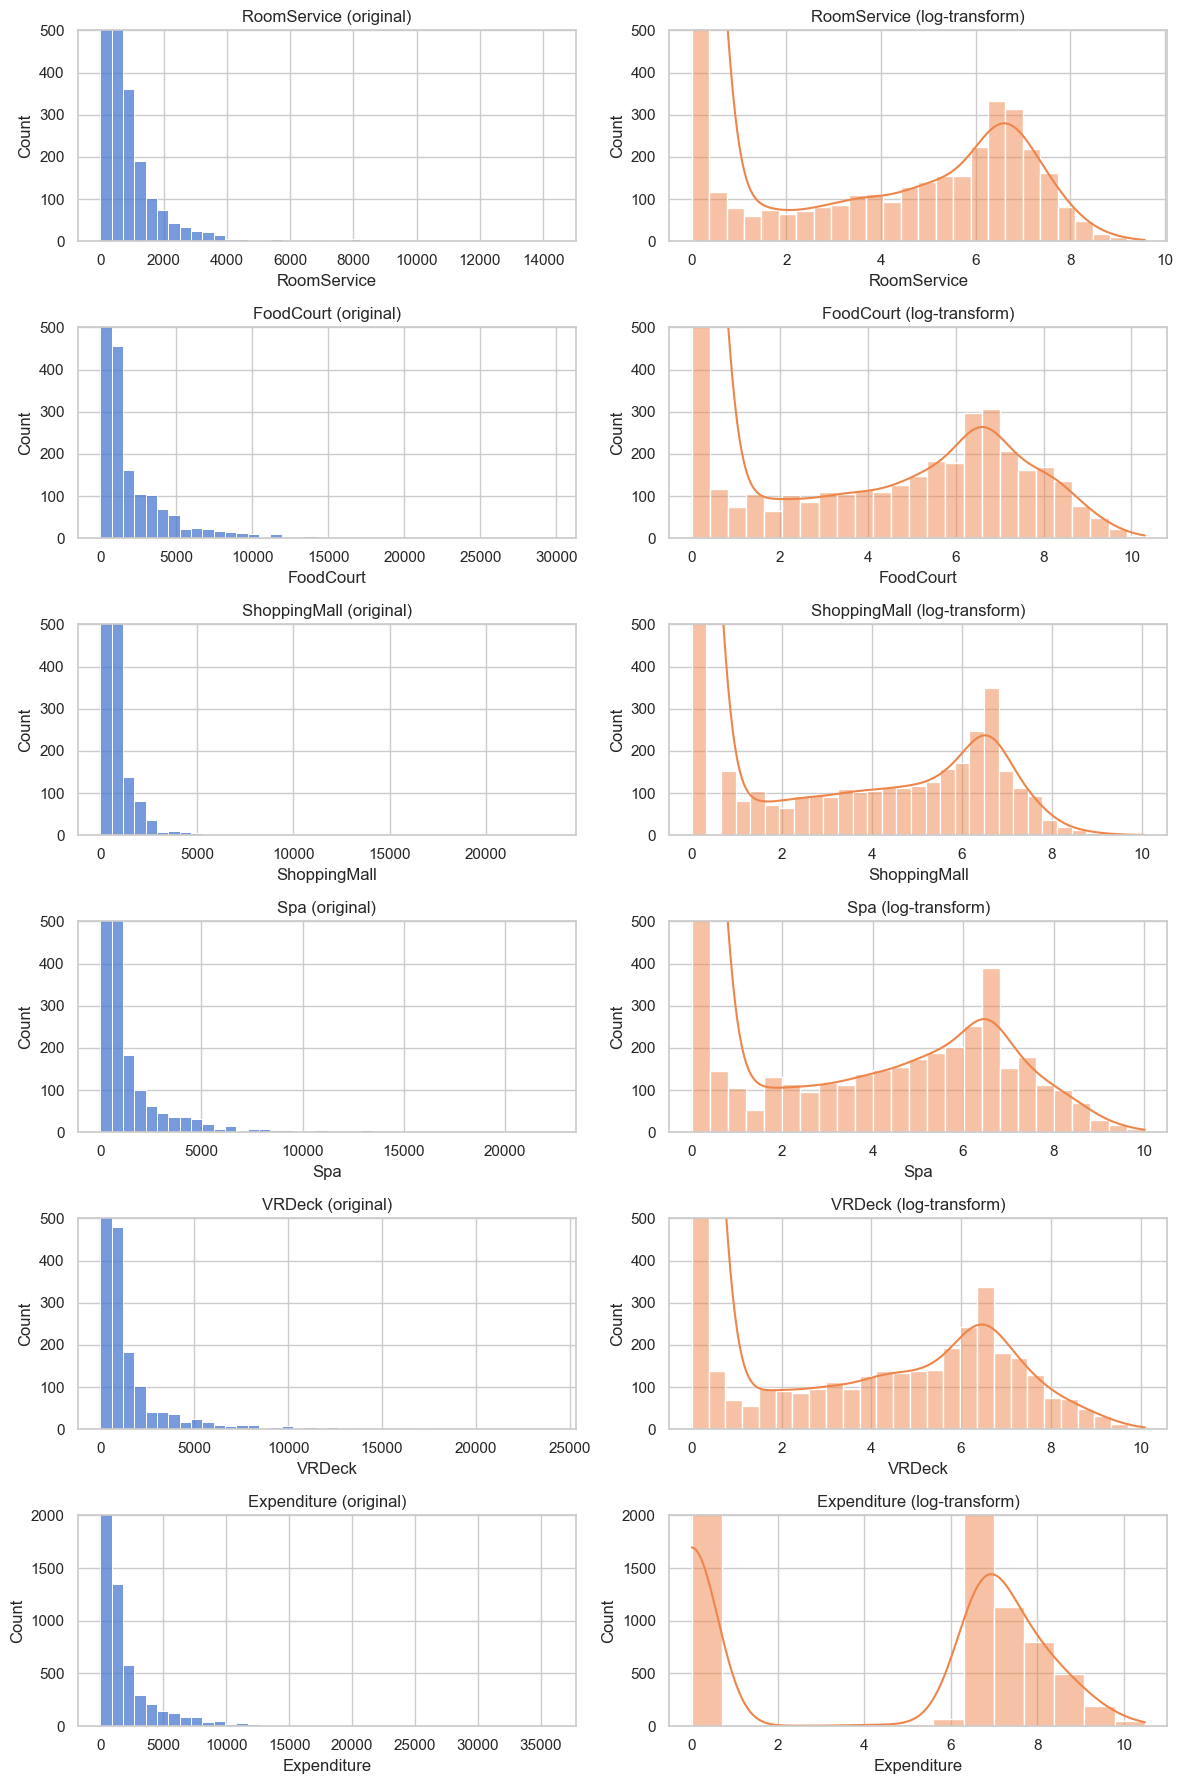

In [45]:
# plot log transform results
exp_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure']

fig = plt.figure(figsize=(12, 18))
for i, col in enumerate(exp_feats):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col], bins=40, kde=False)
    plt.title(f'{col} (original)')
    if i==5:
        plt.ylim([0, 2000])
    else:
        plt.ylim([0, 500])
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1', kde=True)
    plt.title(f'{col} (log-transform)')
    if i==5:
        plt.ylim([0, 2000])
    else:
        plt.ylim([0, 500])
    
fig.tight_layout()
plt.savefig('figures/eda_1/histplot_exp_feats_log.png')

In [46]:
# will use tree-based models
# # apply log transform
# for col in exp_feats:
#     train[col] = np.log(1+train[col])
#     test[col] = np.log(1+test[col])

In [47]:
# last check for missing values and duplicates
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

## Recap and save

In [48]:
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col not in [TARGET]]

numerical = train[FEATURES].select_dtypes(include=np.number).columns
categorical = train[FEATURES].select_dtypes(exclude=np.number).columns

print(f'Target: {TARGET}')
print(f'Features:\n\tnumerical: {numerical.to_list()}\n\tcategorical:{categorical.to_list()}')
print(f'Shapes:\n\ttrain: {train.shape}\n\ttest: {test.shape}')

train.head()

Target: Transported
Features:
	numerical: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure', 'NoSpending', 'CabinNum', 'GroupSize', 'FamilySize']
	categorical:['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide', 'Solo']
Shapes:
	train: (8693, 19)
	test: (4277, 18)


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenditure,NoSpending,CabinDeck,CabinNum,CabinSide,GroupSize,Solo,FamilySize,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0.0,1.0,B,0.0,P,1,True,4,0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1472.0,0.0,F,0.0,S,1,True,4,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,20766.0,0.0,A,0.0,S,2,False,7,0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,10352.0,0.0,A,0.0,S,2,False,7,0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,2182.0,0.0,F,1.0,S,1,True,9,1


In [49]:
# save final data
final_data_path = '../data/final/'
os.makedirs(final_data_path, exist_ok=True)

train.to_csv(final_data_path + 'train.csv', index=False)
test.to_csv(final_data_path + 'test.csv', index=False)